In [1]:
import pandas as pd
import requests
import json
import os
import seaborn as sns
from datetime import datetime
from pymongo import MongoClient
from bson.objectid import ObjectId

In [2]:
client = MongoClient('mongodb+srv://mee-web:<password>@production-cluster-oty65.gcp.mongodb.net/mee?retryWrites=true&w=majority')

In [3]:
db = client['mee']

In [4]:
db.list_collection_names()

['financialStatements',
 'suppliers',
 'ifoodOrders',
 'users',
 'companies',
 'productionRequests',
 'purchases',
 'invoices',
 'ifoodMarketplace',
 'usersProducts',
 'products',
 'changelog',
 'orders',
 'userBill',
 'inventory',
 'customers']

In [5]:
#companies = list(db.companies.find())
simoneId = ObjectId('5fd6046b4afe55001cfe1cee')
colchetesId = ObjectId('5fd604714afe55001cfe1ec6')

In [6]:
simoneDf = db.companies.find_one({ '_id': simoneId })
colchetesDf = db.companies.find_one({ '_id': colchetesId })

In [7]:
sales = pd.DataFrame(list(db.orders.find({ 'company': simoneId, 'status': 'closed' })))
sales.shape

(7151, 28)

## Data Exploration

In [8]:
sales.customer.value_counts()

5f7489a9917c400027f673cb    41
5f749e27917c400027f77f62    40
5f7b54fe1cf796002792d1e7    20
5f7737fcb7d429002770c296    20
5f7ca2db3a902c0027e53cdb    19
                            ..
5f943982b74f2e00276c49d4     1
5f7f75293a902c002752caf4     1
5f89ba946b3d3400273064bc     1
5f871a3abe3537002755ed3d     1
5f92edc5b74f2e00276a4ee0     1
Name: customer, Length: 183, dtype: int64

In [9]:
sales.customer.shape

(7151,)

In [10]:
# sales with customers
sales[pd.isnull(sales.customer) == False].describe()

,total,totalPaid,__v,subtotal,discount,subtotalDiscount,totalDiscount,totalFees
count,715.000000,715.000000,715.000000,715.000000,715.0,715.0,715.0,715.0
mean,39.291608,38.735385,2.472727,37.614406,0.0,0.0,0.0,0.0
std,22.454122,22.039156,1.203530,22.120712,0.0,0.0,0.0,0.0
min,3.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0
25%,24.900000,24.000000,2.000000,22.900000,0.0,0.0,0.0,0.0
50%,30.900000,29.900000,2.000000,28.900000,0.0,0.0,0.0,0.0
75%,47.900000,47.800000,3.000000,45.800000,0.0,0.0,0.0,0.0
max,208.700000,208.700000,8.000000,202.700000,0.0,0.0,0.0,0.0


In [11]:
customers_sales = sales[pd.isnull(sales.customer) == False]

### Questions

- How frequently this customers order?
- Who are the most loyal customers?
- Which days the loyal customers make their orders?
- Qual é a taxa de retenção semanal / mensal e o progresso histórico
- Which customers churned?

#### How frequently customers order?

In [12]:
sales_series = pd.DataFrame({
    'datetime': customers_sales.createdAt,
    'date': customers_sales.createdAt.dt.date,
    'weekday': customers_sales.createdAt.dt.weekday,
    'month': customers_sales.createdAt.dt.month,
    'weekofyear': customers_sales.createdAt.dt.weekofyear,
    'customer': customers_sales.customer
})

In [13]:
# ok lets analyzes all week and see how often this guys order
customers = customers_sales.customer.value_counts().index.to_list()
len(pd.unique(customers))

183

In [14]:
countsDf = sales_series.groupby(['customer', 'weekofyear']).count()['month'].reset_index().rename(columns={ 'month': 'count'})
countsDf = countsDf.set_index(['customer', 'weekofyear'])
df = pd.DataFrame({ 'customer': [], 'weekofyear': [], 'count': [] })
df = df.set_index(['customer', 'weekofyear'])

item = None

for customer in customers:
    item = pd.DataFrame({ 'customer': [customer] * 52, 'weekofyear': list(range(1, 53)) })
    item.reset_index()
    item = item.set_index(['customer', 'weekofyear'])
    item = item.join(countsDf)
    df = pd.concat([df, item])

df = df.reset_index()

In [15]:
means = df.groupby('customer').mean()
means.describe()

,weekofyear,count
count,183.0,183.000000
mean,26.5,1.169977
std,0.0,0.393973
min,26.5,1.000000
25%,26.5,1.000000
50%,26.5,1.000000
75%,26.5,1.145833
max,26.5,3.727273


Na média quando os clientes pedem eles pedem 1 vez na semana. Os clientes que pedem 2+ vezes são minorias. Ou seja temos muito potencial para converter loyal prometers.

Vamos analisar agora a distribução dessa média

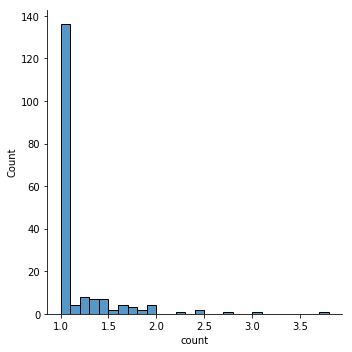

In [16]:
sns.displot(means, x="count", binwidth=0.1)

Ok podemos ver que a maioria esmagadora pede apenas 1 vez na semana e temos alguma variação entre 1 a 2 vezes na semana. Clientes que pedem 3 ou mais vezes na semana são bem raros

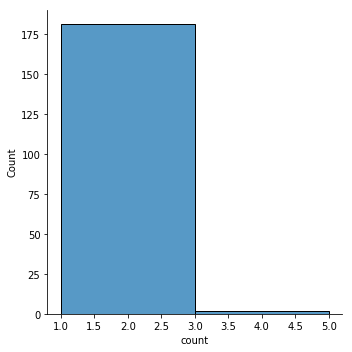

In [17]:
sns.displot(means, x="count", binwidth=2)

Se agruparmos os que pedem entre 1 a 3 e 3 a 5 conseguimos ver que claramente são apenas alguns gatos pingados que são extremamente leais ao longo da semana.

#### Who are the most loyal customers?

In [18]:
sums = df.groupby('customer').sum().sort_values(by='count')
sums

,weekofyear,count
customer,,
5f8f1a350659c000276598fa,1378.0,1.0
5fabf8db52448b0027a3ae6a,1378.0,1.0
5fabf4e852448b0027a3ac60,1378.0,1.0
5fa95f985031fe0027066840,1378.0,1.0
5fa6c16483ff9b0027be8814,1378.0,1.0
...,...,...
5f7ca2db3a902c0027e53cdb,1378.0,19.0
5f7b54fe1cf796002792d1e7,1378.0,20.0
5f7737fcb7d429002770c296,1378.0,20.0


Coisas interessantes de se levar em consideração são:

- Frequencia de compra por semana (média, distribuição, tendência, variação)
- Somatório de compras realizadas

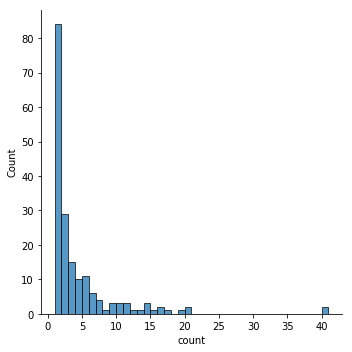

In [19]:
sns.displot(sums, x="count", binwidth=1)

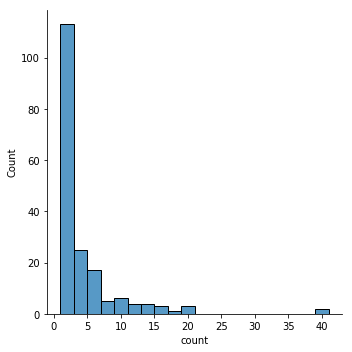

In [20]:
sns.displot(sums, x="count", binwidth=2)

Claramente o volume maior dos clientes já compraram entre 1 a 5 vezes mais ou menos. E temos alguns outliers que compraram entre 20 a 40 vezes

In [21]:
means[means['count'] > 3]

,weekofyear,count
customer,,
5f7489a9917c400027f673cb,26.5,3.727273
5f749e27917c400027f77f62,26.5,3.076923


In [22]:
sums[sums['count'] > 20]

,weekofyear,count
customer,,
5f749e27917c400027f77f62,1378.0,40.0
5f7489a9917c400027f673cb,1378.0,41.0


Podemos ver aqui que temos apenas 2 clientes que se destacam tanto na frequência quanto na quantidade total de pedidos.

#### Which days the loyal customers make their orders?

In [23]:
loyal = list(means[means['count'] > 3].index.astype(str))
loyal

['5f7489a9917c400027f673cb', '5f749e27917c400027f77f62']

In [24]:
sales_series.customer = sales_series.customer.astype(str)
loyal_series = sales_series[sales_series.customer.isin(loyal)]

In [25]:
loyal_series.groupby('weekday').sum()

,month,weekofyear
weekday,,
0,142,607
1,131,556
2,202,857
3,191,801
4,99,414
5,104,437


Parece que segunda, quarta e quinta são os dias que os clientes leais mais pedem.

Talvez outra info interessante seria entender os dias que esses segmentos mais compram. Quais produtos mais comprados por caga segmento

#### Qual é a taxa de retenção semanal / mensal e o progresso histórico

In [26]:
sales_series.groupby('weekofyear').count()

,datetime,date,weekday,month,customer
weekofyear,,,,,
14,1,1,1,1,1
16,2,2,2,2,2
32,1,1,1,1,1
33,1,1,1,1,1
34,2,2,2,2,2
35,2,2,2,2,2
37,1,1,1,1,1
38,4,4,4,4,4
39,2,2,2,2,2


Vamos analisar a semana 40 e 41. Aparentemente só apartir dessa momento que a Simone começou a colocar mais dados no sistema.

Para calcular a taxa de retenção nós precisamos analisar sempre 2 periodos, ou seja se estamos analisando a taxa da semaan 41 temos que comparar com o que aconteceu na semana 40.

Quantas pessoas que compraram na semana 40 retornaram na semana 41?

Retention rate is the percentage of customers a business retains over a given period of time

- Pega os clientes que compraram no intervalo de tempo anterior. Se você está analisando os ultimos 7 dias (1 até 7) você vai pegar o período de 7 até 14 para analisar
- Nesse período de 7 até 14 quantas pessoas retornaram a comprar no periodo 1 até 7?
- Essa taxa é a taxa de retenção

In [27]:
def calc_retention_rate(week):
    week_begin = week - 1
    week_end = week

    customersbegin = sales_series[sales_series.weekofyear == week_begin].customer
    # pego os clientes do 40 que estão na semana 41
    returned = sales_series[(sales_series.weekofyear == week_end) & (sales_series.customer.isin(customersbegin))].shape[0]

    # agora eu só preciso pegar o # de clientes que compraram no 40 e retornaram no 41 e o # total do 40
    total_customers_begin = customersbegin.shape[0]
    total_returning_customers_end = returned
    retention_rate = 0.0
    
    if total_customers_begin != 0:
        retention_rate = (total_returning_customers_end / total_customers_begin) * 100
        # print('Retention rate on week {}: {}%'.format(week, retention_rate))

    return retention_rate

calc_retention_rate(41)

72.5

In [28]:
calc_retention_rate(42)

29.11392405063291

In [29]:
retention_series = sales_series.weekofyear.apply(calc_retention_rate)
sales_series['retention_rate'] = retention_series

In [30]:
sales_series.sort_values('weekofyear')

,datetime,date,weekday,month,weekofyear,customer,retention_rate
129,2020-03-31 19:31:41.728,2020-03-31,1,3,14,5e839c04152d9000264d265c,0.000000
423,2020-04-17 15:42:45.611,2020-04-17,4,4,16,5e839c04152d9000264d265c,0.000000
425,2020-04-17 16:48:23.747,2020-04-17,4,4,16,5e99de379a061b002658aa99,0.000000
3440,2020-08-08 17:12:45.886,2020-08-08,5,8,32,5edbbeca70230a002635ecb1,0.000000
3615,2020-08-15 17:14:35.299,2020-08-15,5,8,33,5edbbeca70230a002635ecb1,100.000000
...,...,...,...,...,...,...,...
7092,2020-12-21 14:53:46.993,2020-12-21,0,12,52,5faffab652448b0027a82f23,13.333333
7091,2020-12-21 14:41:01.953,2020-12-21,0,12,52,5f773906b7d429002770e026,13.333333
7087,2020-12-21 12:59:54.322,2020-12-21,0,12,52,5fc4f1f73c352b00279d9342,13.333333
7104,2020-12-21 16:41:27.631,2020-12-21,0,12,52,5f7de8043a902c00270d3a69,13.333333


In [31]:
retention_history = sales_series.drop_duplicates(subset=['weekofyear']).sort_values('weekofyear')
retention_history

,datetime,date,weekday,month,weekofyear,customer,retention_rate
129,2020-03-31 19:31:41.728,2020-03-31,1,3,14,5e839c04152d9000264d265c,0.000000
423,2020-04-17 15:42:45.611,2020-04-17,4,4,16,5e839c04152d9000264d265c,0.000000
3440,2020-08-08 17:12:45.886,2020-08-08,5,8,32,5edbbeca70230a002635ecb1,0.000000
3615,2020-08-15 17:14:35.299,2020-08-15,5,8,33,5edbbeca70230a002635ecb1,100.000000
3680,2020-08-18 20:04:35.594,2020-08-18,1,8,34,5f3c34b5e97cb800274ac0bf,100.000000
3930,2020-08-27 17:24:45.558,2020-08-27,3,8,35,5edbbeca70230a002635ecb1,100.000000
4288,2020-09-12 16:25:50.098,2020-09-12,5,9,37,5edbbeca70230a002635ecb1,0.000000
4367,2020-09-16 15:12:26.530,2020-09-16,2,9,38,5f622a62fd9b2c00277da8a2,100.000000
4590,2020-09-24 15:18:23.082,2020-09-24,3,9,39,5f638461fd9b2c00277f3959,25.000000
4690,2020-09-30 13:16:09.581,2020-09-30,2,9,40,5f748550917c400027f653d8,0.000000


In [32]:
def diff(week):
    row = retention_history[retention_history.weekofyear == week]
    previous_row = retention_history[retention_history.weekofyear == week - 1]
    has_previous = bool(previous_row.shape[0])
    
    if has_previous:
        return row.iloc[0]['retention_rate'] - previous_row.iloc[0]['retention_rate']
    else:
        return 0.0
        

retention_history['retention_diff'] = retention_history.weekofyear.apply(diff)
retention_history

,datetime,date,weekday,month,weekofyear,customer,retention_rate,retention_diff
129,2020-03-31 19:31:41.728,2020-03-31,1,3,14,5e839c04152d9000264d265c,0.000000,0.000000
423,2020-04-17 15:42:45.611,2020-04-17,4,4,16,5e839c04152d9000264d265c,0.000000,0.000000
3440,2020-08-08 17:12:45.886,2020-08-08,5,8,32,5edbbeca70230a002635ecb1,0.000000,0.000000
3615,2020-08-15 17:14:35.299,2020-08-15,5,8,33,5edbbeca70230a002635ecb1,100.000000,100.000000
3680,2020-08-18 20:04:35.594,2020-08-18,1,8,34,5f3c34b5e97cb800274ac0bf,100.000000,0.000000
3930,2020-08-27 17:24:45.558,2020-08-27,3,8,35,5edbbeca70230a002635ecb1,100.000000,0.000000
4288,2020-09-12 16:25:50.098,2020-09-12,5,9,37,5edbbeca70230a002635ecb1,0.000000,0.000000
4367,2020-09-16 15:12:26.530,2020-09-16,2,9,38,5f622a62fd9b2c00277da8a2,100.000000,100.000000
4590,2020-09-24 15:18:23.082,2020-09-24,3,9,39,5f638461fd9b2c00277f3959,25.000000,-75.000000
4690,2020-09-30 13:16:09.581,2020-09-30,2,9,40,5f748550917c400027f653d8,0.000000,-25.000000


Podemos ver que existe uma grande oscilação na taxa de retenção durante as semanas. Esse histórico e porcentagem comparativa são muito interessantes, mas também é interessante saber quem foi que deu churn em cada semana e também a lista de clientes mais fiéis.

Agora fica a pergunta, o que constitui clientes fieis? Compram toda semana sem falta? Compraram nas 2 ou + semanas seguidas? Tem a média de compra semanal maior? 

E esse intervalo varia muito de tipo de negócio, para restaurantes faz sentindo analisar semana para outros negócios existe uma sazionalidade mensal ou talvez até trimestral

Talvez seja interessante identificar essa sazionalidade de forma estatística, analisar diferentes períodos e ver qual sazionalidade é mais forte e setar ela dinamicamente como default para o negócio

Todo:

- Identificar sazionalidade
- Definir e identificar o que seriam os loyal customers
- Gerar histórico de retenção e a diff
- Guardar lista de clientes que deram churn entre os periodos de analise

#### Which customers churned?

In [41]:
def get_churns(week):
    week_begin = week - 1
    week_end = week
    
    # customers from previous week
    customers_begin = sales_series[sales_series.weekofyear == week_begin].customer
    customers_end = sales_series[sales_series.weekofyear == week_end].customer
    
    previous_set = set(list(customers_begin))
    current_set = set(list(customers_end))
    
    intersec = current_set.intersection(previous_set)
    
    churned = previous_set - intersec


    return list(churned)

sales_series['churned'] = sales_series.weekofyear.apply(get_churns)
sales_series['churned_count'] = sales_series.churned.apply(len)
sales_series.drop_duplicates(subset=['weekofyear']).sort_values('weekofyear')

,datetime,date,weekday,month,weekofyear,customer,retention_rate,churned,churned_count
129,2020-03-31 19:31:41.728,2020-03-31,1,3,14,5e839c04152d9000264d265c,0.000000,[],0
423,2020-04-17 15:42:45.611,2020-04-17,4,4,16,5e839c04152d9000264d265c,0.000000,[],0
3440,2020-08-08 17:12:45.886,2020-08-08,5,8,32,5edbbeca70230a002635ecb1,0.000000,[],0
3615,2020-08-15 17:14:35.299,2020-08-15,5,8,33,5edbbeca70230a002635ecb1,100.000000,[],0
3680,2020-08-18 20:04:35.594,2020-08-18,1,8,34,5f3c34b5e97cb800274ac0bf,100.000000,[],0
3930,2020-08-27 17:24:45.558,2020-08-27,3,8,35,5edbbeca70230a002635ecb1,100.000000,[5f3c34b5e97cb800274ac0bf],1
4288,2020-09-12 16:25:50.098,2020-09-12,5,9,37,5edbbeca70230a002635ecb1,0.000000,[],0
4367,2020-09-16 15:12:26.530,2020-09-16,2,9,38,5f622a62fd9b2c00277da8a2,100.000000,[],0
4590,2020-09-24 15:18:23.082,2020-09-24,3,9,39,5f638461fd9b2c00277f3959,25.000000,"[5f622a62fd9b2c00277da8a2, 5edbbeca70230a00263...",3
4690,2020-09-30 13:16:09.581,2020-09-30,2,9,40,5f748550917c400027f653d8,0.000000,"[5f6f681701ca1900271bb536, 5f638461fd9b2c00277...",2
